<h1><center> Graph Transformer : forecasting hurricanes trajectories

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 28.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00


In [6]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import networkx as nx
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# 1- Data collection

In [7]:
df = pd.concat([pd.read_csv('../data/atlantic.csv'), pd.read_csv('../data/pacific.csv')]).reset_index(drop=True)
# Convert date column as datetime.
df['Date'] = pd.to_datetime(df['Date'] , format= '%Y%m%d')

In [8]:
df.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
      dtype='object')

In [16]:
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Latitude_Hemisphere,Longitude,Longitude_Hemisphere,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851-06-25,00:00:00,,HU,28.0,0,94.8,1,...,37,47,19,17,12,15,7,6,4,5
1,AL011851,UNNAMED,1851-06-25,06:00:00,,HU,28.0,0,95.4,1,...,37,47,19,17,12,15,7,6,4,5
2,AL011851,UNNAMED,1851-06-25,12:00:00,,HU,28.0,0,96.0,1,...,37,47,19,17,12,15,7,6,4,5
3,AL011851,UNNAMED,1851-06-25,18:00:00,,HU,28.1,0,96.5,1,...,37,47,19,17,12,15,7,6,4,5
4,AL011851,UNNAMED,1851-06-25,21:00:00,L,HU,28.2,0,96.8,1,...,37,47,19,17,12,15,7,6,4,5


# 2- Graph representation

In [17]:
def weight_for_edge(i, j):
    if j == i + 1:
        return 1
    elif (j == i + 2) or (j == i + 3):
        return 0.5
    elif (j == i + 4) or (j == i + 5):
        return 0.1
    else:
        return 0

def get_local_graph(graph, node):
    graph_copy = graph.copy()
    subgraph = nx.reverse(nx.ego_graph(nx.reverse(graph_copy), node, radius=1))

    attr_node_0 = subgraph.nodes[list(subgraph.nodes)[0]]["localisation"]
    for node in subgraph.nodes:
        subgraph.nodes[node]["localisation"] = subgraph.nodes[node]["localisation"] - attr_node_0

    return subgraph

def get_dic_graph(df, loc_feature_names, weather_feature_names, max_seq_lenght=16):
    dic_graph = {}
    dic_X = {}
    dic_Y = {}

    for hurricane in df["ID"].unique():
        df_hurr = df[df["ID"] == hurricane]

        if len(df_hurr) > 2:
            y_index = random.randint(2, len(df_hurr)-1)
            y = df_hurr[loc_feature_names].iloc[y_index].apply(float)

            x = df_hurr[loc_feature_names + weather_feature_names].iloc[:y_index].iloc[-max_seq_lenght:].applymap(float)

            # Standardization of weather features
            scaler = StandardScaler()
            x[weather_feature_names] = scaler.fit_transform(x[weather_feature_names])

            graph = nx.DiGraph()
            for i in range(len(x)):
                graph.add_node(i, localisation=x[loc_feature_names].values[i], weather=x[weather_feature_names].values[i])

            for i in range(len(x)):
                for j in range(i+1, len(x)):
                    if i + 5 >= j:
                        graph.add_edge(i, j, weight=weight_for_edge(i,j))

            # Localisation features to local co-ordinates
            attr_node_0 = graph.nodes[list(graph.nodes)[0]]["localisation"]
            for node in graph.nodes:
                graph.nodes[node]["localisation"] = graph.nodes[node]["localisation"] - attr_node_0
            y -= attr_node_0

            # It would take approximately 1 hour to compute the local graph for all nodes.
            # for node in graph.nodes:
            #     graph.nodes[node]["subgraph"] = get_local_graph(graph, node)


            dic_graph[hurricane] = graph
            dic_X[hurricane] = x
            dic_Y[hurricane] = y

    return dic_graph, dic_X, dic_Y

## a- Stratifying

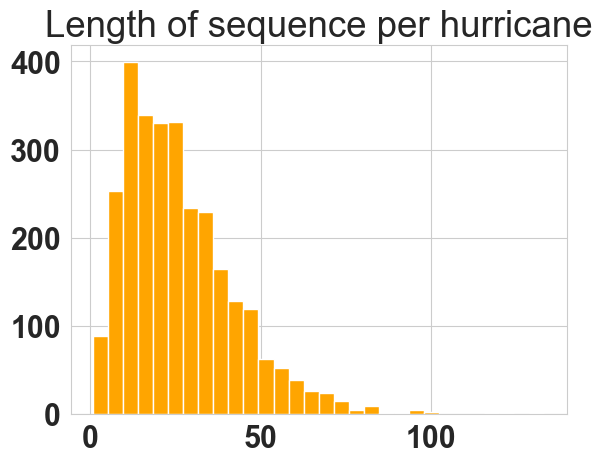

In [75]:
df.groupby("ID").count()["Date"].hist(color="orange", bins=30)
plt.title("Length of sequence per hurricane")
plt.show()

In [19]:
n_bins = 20
bins_for_stratifying = pd.cut(df.groupby("ID").count()["Date"], bins=n_bins)

bins_to_merge = bins_for_stratifying.value_counts()[bins_for_stratifying.value_counts() < 10].index
bins_for_stratifying_copy = bins_for_stratifying.copy()
good_bins = []
mapping = {}

for i in range(len(bins_for_stratifying_copy.cat.categories)):
    bin = bins_for_stratifying_copy.cat.categories[i]
    if bins_for_stratifying.value_counts()[bin] > 10:
        good_bins.append(bin)
        mapping[bin] = bin
    elif bin.left < good_bins[-1].right:
        mapping[bin] = good_bins[-1]
        pass
    else:
        bin_to_be_associated = [bin]
        number_in_bin = bins_for_stratifying.value_counts()[bin]
        to_add = True
        left = bin.left
        j = i
        while number_in_bin < 10:
            if j == len(bins_for_stratifying_copy.cat.categories)-1:
                to_add = False
                if bin.right != good_bins[-1].right:
                    good_bins[-1] = pd.Interval(good_bins[-1].left, bin.right)
                    mapping[bin] = pd.Interval(good_bins[-1].left, bin.right)
                    for bin_mapped in mapping.keys():
                        if mapping[bin_mapped].right == left:
                            mapping[bin_mapped] = pd.Interval(mapping[bin_mapped].left, bin.right)
                break
            bin = bins_for_stratifying_copy.cat.categories[j+1]
            number_in_bin += bins_for_stratifying.value_counts()[bin]
            j += 1
            bin_to_be_associated.append(bin)

        if to_add:
            right = bin.right
            good_bins.append(pd.Interval(left, right))
            for bin in bin_to_be_associated:
                mapping[bin] = pd.Interval(left, right)

bins_for_stratifying_copy = bins_for_stratifying_copy.apply(lambda x: mapping[x])

In [20]:
hurricane_name_train, hurricane_name_test = train_test_split(bins_for_stratifying_copy, test_size=0.2, stratify=bins_for_stratifying_copy, random_state=42)
hurricane_name_val, hurricane_name_test = train_test_split(hurricane_name_test, test_size=0.5, stratify=hurricane_name_test, random_state=42)

In [21]:
df_train = df[df["ID"].isin(hurricane_name_train.index)]
df_val = df[df["ID"].isin(hurricane_name_val.index)]
df_test = df[df["ID"].isin(hurricane_name_test.index)]

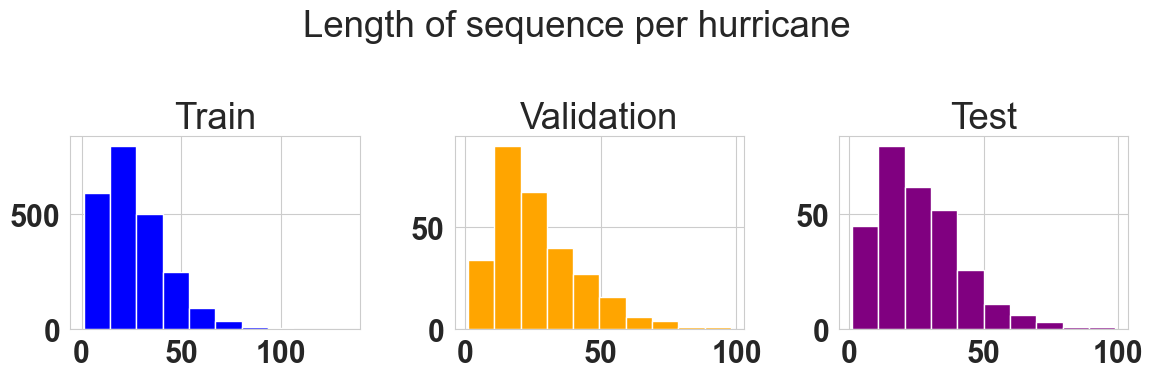

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

df_train.groupby("ID").count()["Date"].hist(ax=axs[0], color = "blue")
axs[0].set_title("Train")
df_val.groupby("ID").count()["Date"].hist(ax=axs[1], color = "orange")
axs[1].set_title("Validation")
df_test.groupby("ID").count()["Date"].hist(ax=axs[2], color = "purple")
axs[2].set_title("Test")

fig.suptitle("Length of sequence per hurricane")
fig.tight_layout()
plt.show()

In [23]:
weather_feature_names = ['Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW']
dic_graph_train, dic_X_train, dic_Y_train = get_dic_graph(df_train, loc_feature_names=["Latitude", "Longitude"], weather_feature_names=weather_feature_names)
dic_graph_val, dic_X_val, dic_Y_val = get_dic_graph(df_val, loc_feature_names=["Latitude", "Longitude"], weather_feature_names=weather_feature_names)
dic_graph_test, dic_X_test, dic_Y_test = get_dic_graph(df_test, loc_feature_names=["Latitude", "Longitude"], weather_feature_names=weather_feature_names)

/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_14276/900215744.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x = df_hurr[loc_feature_names + weather_feature_names].iloc[:y_index].iloc[-max_seq_lenght:].applymap(float)
/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_14276/900215744.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x = df_hurr[loc_feature_names + weather_feature_names].iloc[:y_index].iloc[-max_seq_lenght:].applymap(float)
/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_14276/900215744.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x = df_hurr[loc_feature_names + weather_feature_names].iloc[:y_index].iloc[-max_seq_lenght:].applymap(float)
/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_14276/900215744.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x = df_hu

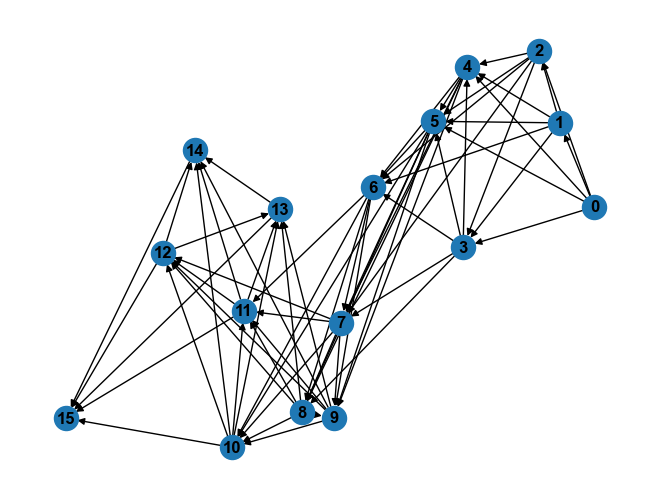

In [24]:
nx.draw(dic_graph_train[list(dic_graph_train.keys())[1]], with_labels=True, font_weight='bold')
plt.show()

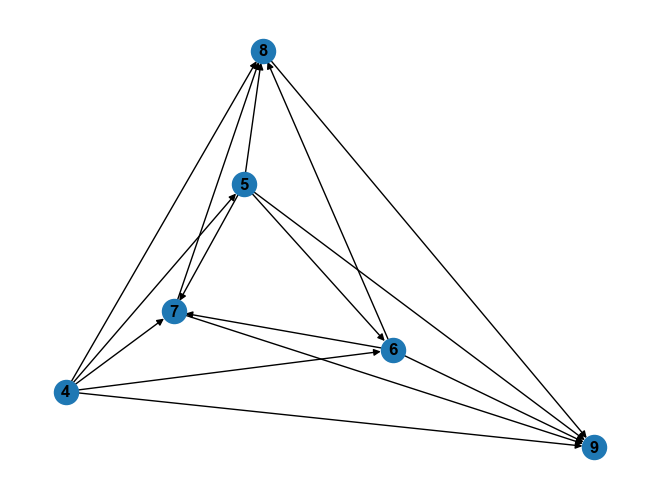

In [25]:
nx.draw(get_local_graph(dic_graph_train[list(dic_graph_train.keys())[1]], 9), with_labels=True, font_weight='bold')

In [26]:
get_local_graph(dic_graph_train[list(dic_graph_train.keys())[1]], 9).nodes(data=True)

NodeDataView({4: {'localisation': array([0., 0.]), 'weather': array([-0.55381862,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])}, 5: {'localisation': array([0.5, 2. ]), 'weather': array([0.1278043, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])}, 6: {'localisation': array([0.7, 3.9]), 'weather': array([0.1278043, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])}, 7: {'localisation': array([1.2, 6. ]), 'weather': array([0.80942721, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 8: {'localisation': array([1.5, 7.

#### Training dataset

In [27]:
def create_data_loader(dic_graph, dic_Y, batch_size, type_dataset):
    data_list = []
    for hurricane in dic_graph:
        x = torch.tensor(np.array([np.concatenate(list(dic_graph[hurricane].nodes.data()[i].values())) for i in range(len(dic_graph[hurricane].nodes))]), dtype=torch.float)

        # Convert labels to PyTorch tensor
        y = torch.tensor(dic_Y[hurricane].values, dtype=torch.float).unsqueeze(0)

        # Convert edge indices to PyTorch tensor
        edge_index = torch.tensor(list(dic_graph[hurricane].edges()),dtype=torch.long).transpose(0, 1)

        # create edge features
        edge_attr = torch.tensor([dic_graph[hurricane].edges()[edge]["weight"] for edge in dic_graph[hurricane].edges()], dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data_list.append(data)

    print(f"{type_dataset} data size: {len(data_list)}")
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)
    return loader

In [28]:
batch_size = 32

train_loader = create_data_loader(dic_graph_train, dic_Y_train, batch_size, type_dataset="Training")
val_loader = create_data_loader(dic_graph_val, dic_Y_val, batch_size, type_dataset="Validation")
test_loader = create_data_loader(dic_graph_test, dic_Y_test, batch_size, type_dataset="Test")

Training data size: 2268
Validation data size: 282
Test data size: 281


# 3 - Training

In [29]:
from torch_geometric.nn import GCNConv, GATv2Conv

class Model(nn.Module):
  def __init__(self, input_size_gcn, hidden_size_gcn, output_size_gcn, wind_features_size, nhead_transformer, output_size_transformer, num_layers_transformer, output_size):
    super().__init__()

    self.conv1 = GCNConv(input_size_gcn, hidden_size_gcn)
    self.conv2 = GCNConv(hidden_size_gcn, output_size_gcn)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=output_size_gcn + wind_features_size, nhead=nhead_transformer, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers_transformer)
    self.fc = nn.Linear(output_size_gcn + wind_features_size, output_size_transformer)

    self.linear = nn.Linear(output_size_transformer, output_size)

    self.elu = nn.ELU()

  def forward(self, x, edge_index, edge_weight):
    loc_features = x[:, :2]
    wind_features = x[:, 2:]

    # Graph convolution
    loc_features = self.conv1(loc_features, edge_index, edge_weight)
    loc_features = self.elu(loc_features)
    loc_features = self.conv2(loc_features, edge_index, edge_weight)
    loc_features = self.elu(loc_features)

    # Transformer encoder
    concatenated_input = torch.cat((loc_features, wind_features), dim=1)
    transformer_output = self.transformer_encoder(concatenated_input.unsqueeze(0))
    transformer_output = self.fc(transformer_output.squeeze())
    transformer_output = transformer_output[-1, :]  # Extract representation of the final token

    # Final linear layer
    output = self.linear(transformer_output)
    # output = self.elu(output)

    return output.unsqueeze(0)

In [30]:
def evaluate(model, loss_fcn, device, dataloader, batch_size):
    loss_list_batch = []

    model.eval()
    for i, val_batch in enumerate(dataloader):
        val_batch = val_batch.to(device)
        output = torch.cat([model(val_batch.x[val_batch.batch==j, :],
                           val_batch.edge_index[:, (val_batch.ptr[j] <= val_batch.edge_index[0, :]) & (val_batch.edge_index[0, :] <  val_batch.ptr[j+1])] \
                           - val_batch.edge_index[:, (val_batch.ptr[j] <= val_batch.edge_index[0, :]) & (val_batch.edge_index[0, :] <  val_batch.ptr[j+1])].min(), \
                           val_batch.edge_attr[(val_batch.ptr[j] <= val_batch.edge_index[0, :]) & (val_batch.edge_index[0, :] <  val_batch.ptr[j+1])]) \
                      for j in range(val_batch.y.shape[0])], dim=0)
        # output = model(val_batch.x, val_batch.edge_index)
        loss_test = loss_fcn(output, val_batch.y)

        loss_list_batch.append(loss_test.item())

    return np.array(loss_list_batch).mean()

In [31]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader, batch_size, scheduler = None):

    epoch_list = []
    scores_list = []
    all_losses= []
    best_model_state_dict = None
    best_score = 0

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []

        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            output = torch.cat([model(train_batch_device.x[train_batch_device.batch==j, :],
                           train_batch_device.edge_index[:, (train_batch_device.ptr[j] <= train_batch_device.edge_index[0, :]) & (train_batch_device.edge_index[0, :] <  train_batch_device.ptr[j+1])] \
                           - train_batch_device.edge_index[:, (train_batch_device.ptr[j] <= train_batch_device.edge_index[0, :]) & (train_batch_device.edge_index[0, :] <  train_batch_device.ptr[j+1])].min(), \
                           train_batch_device.edge_attr[(train_batch_device.ptr[j] <= train_batch_device.edge_index[0, :]) & (train_batch_device.edge_index[0, :] <  train_batch_device.ptr[j+1])]) \
                      for j in range(train_batch_device.y.shape[0])], dim=0)
            # output = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(output, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        loss_data = np.array(losses).mean()
        all_losses.append(loss_data)
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if scheduler is not None:
            scheduler.step()

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            score = evaluate(model, loss_fcn, device, val_dataloader, batch_size)
            print("Loss on val set: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)
            # Check if the current model is the best one so far
            if score > best_score:
                best_score = score
                best_model_state_dict = model.state_dict()
    # Load the best model parameters
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
    return epoch_list, scores_list, all_losses


In [32]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = Model(input_size_gcn=2,
              hidden_size_gcn=18,
              output_size_gcn=18,
              wind_features_size=next(iter(train_loader)).x.shape[1]-2,
              nhead_transformer=4,
              output_size_transformer=64,
              num_layers_transformer=4,
              output_size=2).to(device)

# Define the loss function and optimizer
loss_fcn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_epochs=100


Device:  cpu


In [ ]:
epoch_list, scores_list, all_losses = train(model, loss_fcn, device, optimizer, max_epochs, train_loader, val_loader, batch_size, scheduler=None)

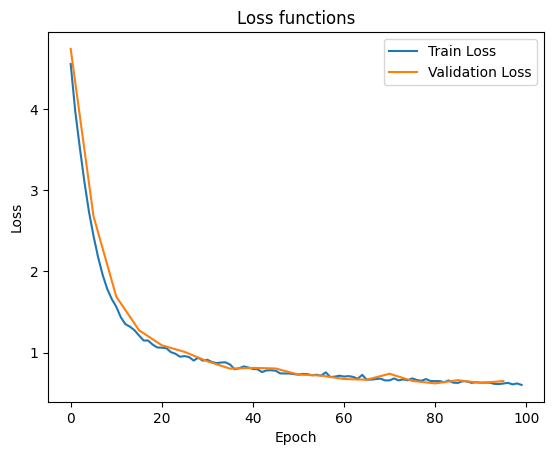

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(all_losses, label="Train Loss")
plt.plot([i*5 for i in range(len(scores_list))], scores_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss functions")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "../models/best_model_weights.pth")

# 4- Evaluation

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

model = Model(input_size_gcn=2,
              hidden_size_gcn=18,
              output_size_gcn=18,
              wind_features_size=next(iter(train_loader)).x.shape[1]-2,
              nhead_transformer=4,
              output_size_transformer=64,
              num_layers_transformer=4,
              output_size=2).to(device)

model.load_state_dict(torch.load('../models/best_model_weights.pth', map_location=device))


Device:  cpu


<All keys matched successfully>

In [44]:
loss_fcn = nn.SmoothL1Loss()
loss_fcn_bis = nn.L1Loss()

print(f"Score with L1smooth metric on test set: {evaluate(model, loss_fcn, device, test_loader, batch_size):.2f}")
print(f"Score with L1 metric on test set: {evaluate(model, loss_fcn_bis, device, test_loader, batch_size):.2f}")

Score with L1smooth metric on test set: 0.63
Score with L1 metric on test set: 0.99


In [53]:
test_batch = next(iter(test_loader))
print(test_batch.x)

tensor([[ 0.0000,  0.0000, -1.5889,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1000, -2.6000, -1.3513,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1000, -4.7000, -1.1137,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.5000,  5.1000,  0.1601,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.2000,  5.8000,  1.4412,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.8000,  6.7000,  1.4412,  ...,  0.0000,  0.0000,  0.0000]])


(8, 16)
(16, 16)
(8, 16)
(5, 16)
(4, 16)


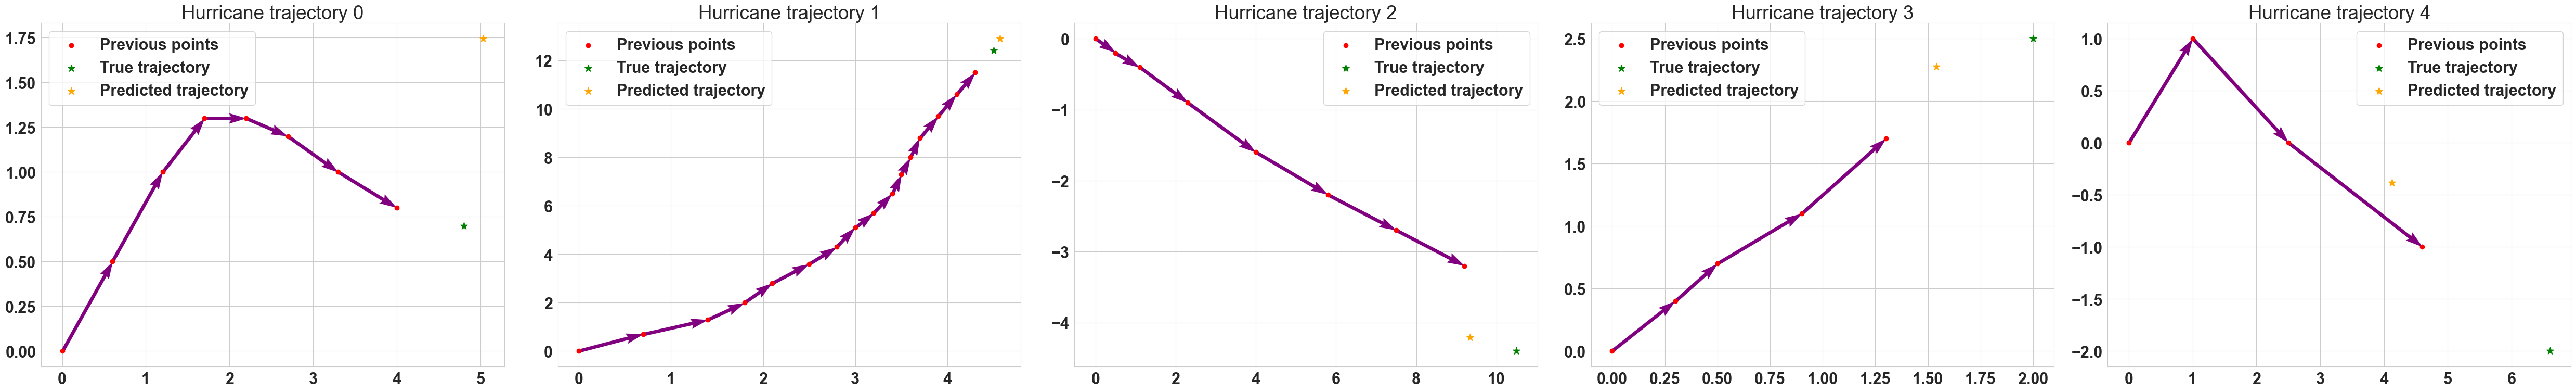

In [74]:

import matplotlib.pyplot as plt
import torch

def plot_predicted_trajectory(model, device, dataloader, batch_size, n_samples):
    model.eval()
    fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 10, 8))  # 5 pouces de largeur pour chaque subplot

    for i, test_batch in enumerate(dataloader):
        test_batch = test_batch.to(device)
        output = torch.cat([model(test_batch.x[test_batch.batch==j, :],
                           test_batch.edge_index[:, (test_batch.ptr[j] <= test_batch.edge_index[0, :]) & (test_batch.edge_index[0, :] <  test_batch.ptr[j+1])] \
                           - test_batch.edge_index[:, (test_batch.ptr[j] <= test_batch.edge_index[0, :]) & (test_batch.edge_index[0, :] <  test_batch.ptr[j+1])].min(), \
                           test_batch.edge_attr[(test_batch.ptr[j] <= test_batch.edge_index[0, :]) & (test_batch.edge_index[0, :] <  test_batch.ptr[j+1])]) \
                      for j in range(test_batch.y.shape[0])], dim=0)
        break 
    
    for i in range(n_samples):
        prev_points = test_batch.x[test_batch.batch == i, :].cpu().detach().numpy()
        
        if n_samples == 1:
            ax = axs
        else:
            ax = axs[i]

        for j in range(len(prev_points)-1):
            ax.quiver(prev_points[j, 0], prev_points[j, 1],
                      prev_points[j+1, 0] - prev_points[j, 0], prev_points[j+1, 1] - prev_points[j, 1],
                      angles='xy', scale_units='xy', scale=1, color='purple')

        ax.scatter(prev_points[:, 0], prev_points[:, 1], label="Previous points", color="red")
        ax.scatter(test_batch.y[i].cpu().detach().numpy()[0], test_batch.y[i].cpu().detach().numpy()[1], label="True trajectory", color = "green", marker = '*', s=100)
        ax.scatter(output[i].cpu().detach().numpy()[0], output[i].cpu().detach().numpy()[1], label="Predicted trajectory",color = "orange",marker = '*', s=100)
        
        ax.legend()
        ax.title.set_text(f"Hurricane trajectory {i}")
    
    plt.tight_layout()
    plt.show()


plot_predicted_trajectory(model, device, test_loader, batch_size, n_samples=6)

In [ ]:
# faire un plot de l'erreur en fonction du nombre de point en amont du cyclone

def lat_long_error(ground_truth, predicted):
    return np.sqrt((ground_truth[0] - predicted[0])**2 + (ground_truth[1] - predicted[1])**2)

# 5- Hierarchical agregation and cumulative errors